In [2]:
import context
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

******************************
context imported. Front of path:
/Users/nduboc/repos/numeric_2024
back of path: /Users/nduboc/opt/miniconda3/envs/numeric_2024/lib/python3.12/site-packages
******************************

through /Users/nduboc/repos/numeric_2024/notebooks/lab5/context.py


# Problem Initial

In [3]:
class Integ54(Integrator):
    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions

            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return temp_w, temp_b, temp_e

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        temp_w, temp_b, temp_e = self.find_temp(y)

        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        bare = 1.0 - y[0] - y[1] 
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[0] = y[0] * (beta_w * bare - user.chi) 
        f[1] = y[1] * (beta_b * bare - user.chi)
        
        return f

In [4]:
# higher black daisy fraction
theSolver1 = Integ54('initial1.yaml')
timevals1, yvals1, errorlis1t = theSolver1.timeloop5fixed()
daisies1 = pd.DataFrame(yvals1, columns=['white', 'black'])

temp_w1 = []
temp_b1 = []
temp_e1 = []
for i in range(len(timevals1)):
    w1,b1,e1 = theSolver1.find_temp(yvals1[i,:])
    temp_w1.append(w1- 273.15)
    temp_b1.append(b1- 273.15)
    temp_e1.append(e1- 273.15)

In [5]:
# 0 black daisy fraction
import matplotlib.pyplot as plt
import pandas as pd

theSolver = Integ54('initial.yaml')
timevals, yvals, errorlist = theSolver.timeloop5fixed()
daisies = pd.DataFrame(yvals, columns=['white', 'black'])

temp_w = []
temp_b = []
temp_e = []
for i in range(len(timevals)):
    w,b,e = theSolver.find_temp(yvals[i,:])
    temp_w.append(w- 273.15)
    temp_b.append(b- 273.15)
    temp_e.append(e- 273.15)

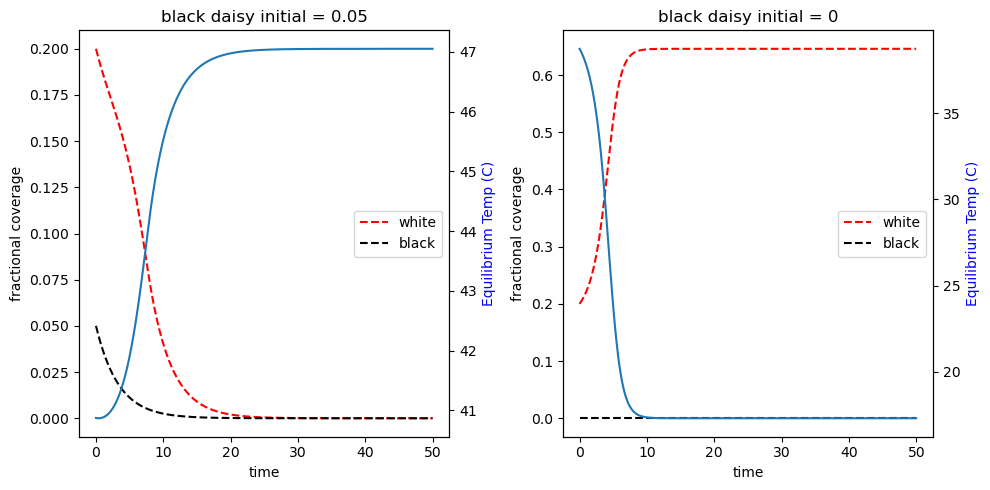

In [21]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(timevals1,daisies1['white'],linestyle='--', color='r', label='white')
ax1.plot(timevals1, daisies1['black'],linestyle='--', color='k', label='black')
ax1.set_title('black daisy initial = 0.05')
ax1.set_xlabel('time')
ax1.set_ylabel('fractional coverage')
ax1.legend(loc='center right')
ax3 = ax1.twinx()
ax3.plot(timevals,temp_e1,label='equilibirum')
ax3.set_ylabel('Equilibrium Temp (C)',color='blue')

ax2.plot(timevals, daisies['white'],linestyle='--', color='r', label='white')
ax2.plot(timevals, daisies['black'],linestyle='--', color='k', label='black')
ax2.set_title('black daisy initial = 0')
ax2.set_xlabel('time')
ax2.set_ylabel('fractional coverage')
ax2.legend(loc='center right')
ax4 = ax2.twinx()
ax4.plot(timevals,temp_e,label='equilibirum')
ax4.set_ylabel('Equilibrium Temp (C)',color='blue')


fig.tight_layout()

#fig, (ax3,ax4) = plt.subplots(1,2,figsize=(10,5))
#ax3.plot(timevals,temp_w1,'r',label='white daisies')
#ax3.plot(timevals,temp_b1,'k',label='black daisies')
#ax3.plot(timevals,temp_e1,label='equilibirum')
#ax3.set_ylabel('Temperature (C)')
#ax3.legend()

#ax4.plot(timevals,temp_w,'r',label='white daisies',)
#ax4.plot(timevals,temp_b,'k',label='black daisies')
#ax4.plot(timevals,temp_e,label='equilibirum')
#ax4.set_ylabel('Temperature (C)')
#ax4.legend()

fig.tight_layout()

The left column plots above represent the scenario where the initial black daisy population is 5%. The right column plots represent the scenario where the initial black daisy population is 0. The top plots show the fraction of both daisies and how they change with time. The bottom plots show how the temperature of black daisies, white dasies, and the equilibirum temperature. 

### part 1

In the scenario with an initial black daisy coverage of 0, the equilibrium temperature decreases. This is consistent with a higher population of white daisies; since their albedo is much higher, the equilibrium temperature will decrease with a high fractional coverage. The temperature does decrease but reaches a steady state greater than 0C, allowing for the increased fraction of white daisies to stay alive. 

In the scenario with a 5% coverage of black daisies, the equilibrium temperature increases. This is consistent given the lower albedo of black daisies, allowing more of the solar radiation to warm up the planet and increasing the equilibrium temperature. The fractional coverage of both white and black daisies goes to zero in this scenario. We can see the reason from this in the temperature plot; a greater coverage of black daisies increases the initial equilibrium temperature to be above 40C, with the presence of black daisies, this temperature increases, essentially killing all black daisies almost immediately. The white daisies are inherently cooler, starting below 40C. However, given the increase in temperature due to the black daisies, the white daisy temperature increases to a point where they too also die. 


### part 2 


Text(0.5, 0.98, 'black daisy concentration = 0.4\nwhite daisy concentration = 0.5')

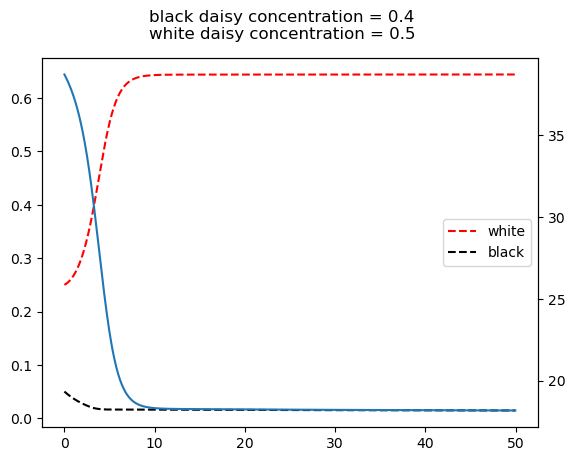

In [38]:
# constant blackconc, varying whiteconc for steady state
theSolver2 = Integ54('initial2.yaml')
timevals2, yvals2, errorlist2 = theSolver2.timeloop5fixed()
daisies2 = pd.DataFrame(yvals2, columns=['white', 'black'])

temp_w2 = []
temp_b2 = []
temp_e2 = []
for i in range(len(timevals)):
    w2,b2,e2 = theSolver2.find_temp(yvals2[i,:])
    temp_w2.append(w2- 273.15)
    temp_b2.append(b2- 273.15)
    temp_e2.append(e2- 273.15)

fig, ax1 = plt.subplots(1,1)
ax1.plot(timevals2,daisies2['white'],'--r',label='white')
ax1.plot(timevals2,daisies2['black'],'--k',label='black')
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(timevals2,temp_e2)

# fig.suptitle('black daisy concentration = 0.4\nwhite daisy concentration = 0.5')

In [17]:
np.min(daisies2['black'])

0.014547762285471987

In order to get a non-zero steady state the fraction of white daisy needs to be increased by at least 0.1. The plot above depicts the initial concentration of white daisies of 0.25, in order to allow the black daisy concentration to reach a minimum of 1% coverage. The higher initial concentration of white daisies "overwrites" the impact of the initial black daisy concentration. This allows the temperature cool instead of warm, allowing white daisies to grow to an equilibrium. However, the initial presence of black daisies keeps the temperature high enough to allow a small concentration of black daisies to continue to grow. 

### Part 3

Text(0.5, 0.98, 'black daisy concentration = 0.4\nwhite daisy concentration = 0.5')

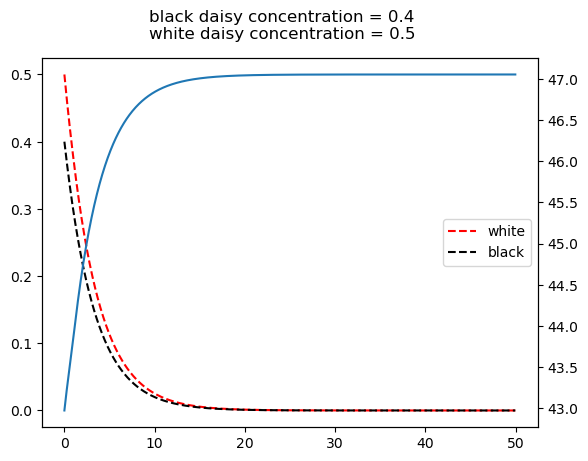

In [39]:
# blackconc = 0.25 whiteconc = 0.25
theSolver3 = Integ54('initial3.yaml')
timevals3, yvals3, errorlist3 = theSolver3.timeloop5fixed()
daisies3 = pd.DataFrame(yvals3, columns=['white', 'black'])

temp_w3 = []
temp_b3 = []
temp_e3 = []
for i in range(len(timevals)):
    w3,b3,e3 = theSolver3.find_temp(yvals3[i,:])
    temp_w3.append(w3- 273.15)
    temp_b3.append(b3- 273.15)
    temp_e3.append(e3- 273.15)

fig, ax1 = plt.subplots(1,1)
ax1.plot(timevals3,daisies3['white'],'--r',label='white')
ax1.plot(timevals3,daisies3['black'],'--k',label='black')
ax1.legend(loc='center right')

ax2 = ax1.twinx()
ax2.plot(timevals3,temp_e3)
fig.suptitle('black daisy concentration = 0.4\nwhite daisy concentration = 0.5')

42.972792509096564

# Problem adaptive

### part 1 

Text(0.5, 1.0, 'size of timesteps')

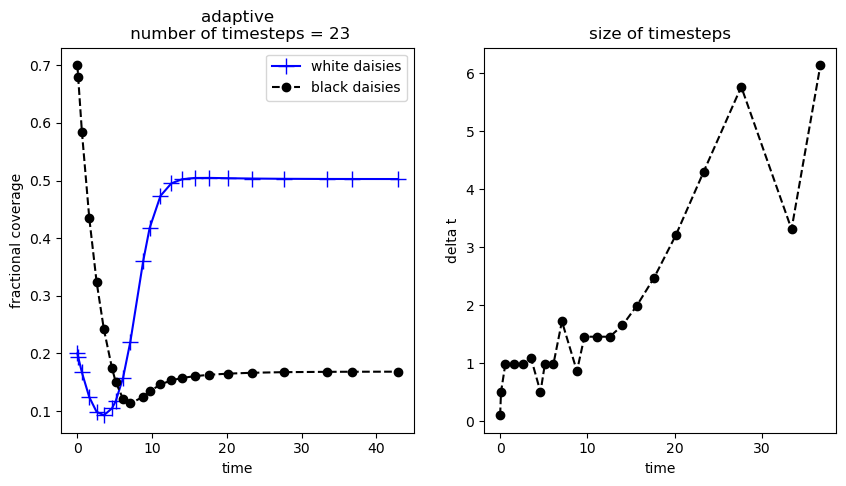

In [8]:
theSolver = Integ54('adapt.yaml')
a_timeVals, a_yVals, a_errorList = theSolver.timeloop5Err()

a_yvals = pd.DataFrame.from_records(a_yVals, columns=['white', 'black'])

thefig, (ax1,ax2) = plt.subplots(1, 2,figsize=(10,5))

points, = ax1.plot(a_timeVals, a_yvals['white'], '-b+', label='white daisies')
points.set_markersize(12)
theLine1, = ax1.plot(a_timeVals, a_yvals['black'], '--ko', label='black daisies')
ax1.set_title(f'adaptive\n number of timesteps = {len(a_timeVals)}')
ax1.set_xlabel('time')
#ax2 = theAx.twiny()
#ax2.plot(np.diff(a_timeVals))
ax1.set_ylabel('fractional coverage')
ax1.legend(loc='best')

ax2.plot(a_timeVals[:-1],np.diff(a_timeVals),'--ko')
ax2.set_ylabel('delta t')
ax2.set_xlabel('time')
ax2.set_title('size of timesteps')

### part 2

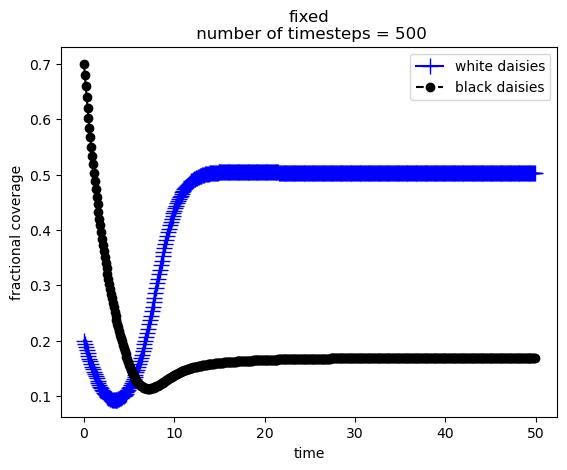

In [17]:
f_timeVals, f_yVals, f_errorList = theSolver.timeloop5fixed()

f_yvals = pd.DataFrame.from_records(f_yVals, columns=['white', 'black'])

thefig, theAx = plt.subplots(1, 1)

points, = theAx.plot(f_timeVals, f_yvals['white'], '-b+', label='white daisies')
points.set_markersize(12)
theLine1, = theAx.plot(f_timeVals, f_yvals['black'], '--ko', label='black daisies')
theAx.set_title(f'fixed\n number of timesteps = {len(f_timeVals)}')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='best')

# timeVals,yVals,errorList=theSolver.timeloop5fixed()
# whiteDaisies=[frac[0] for frac in yVals]

Text(0.5, 0.98, 'size of timesteps between adaptive and fixed')

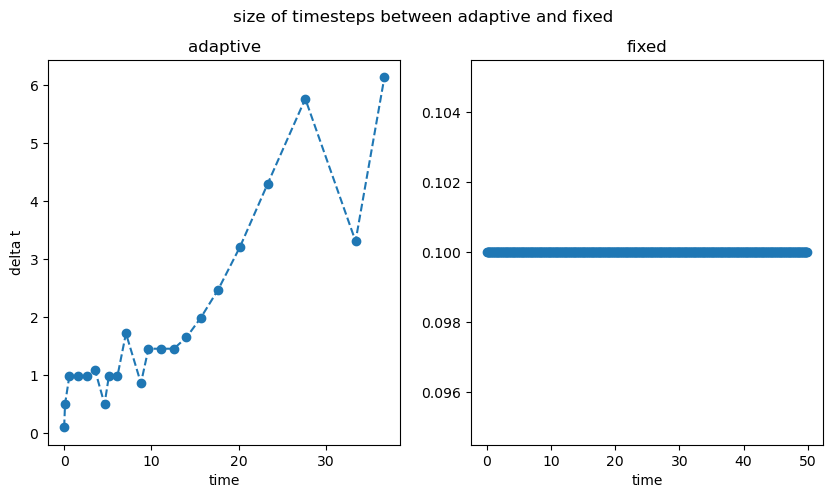

In [18]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.plot(a_timeVals[:-1],np.diff(a_timeVals),'--o')
ax1.set_title('adaptive')
ax1.set_ylabel('delta t')
ax1.set_xlabel('time')

ax2.plot(f_timeVals,[0.1 for i in range(len(f_timeVals))],'--o')
ax2.set_title('fixed')
ax2.set_xlabel('time')

fig.suptitle('size of timesteps between adaptive and fixed')


### Part 3
The fixed timestep algorithm completes the simulation with 500 timesteps. Conversely the adaptive algorithm finished the same simulation but with 23 timesteps. This means the fixed timestep algorithm would need to be 95% faster in order to give the same performance as the adaptive timeloop. 

# Problem Predator

In [93]:
class Integ54_rabbits(Integrator):
    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc rabbitconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc,self.initvars.rabbitconc])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions

            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return temp_w, temp_b, temp_e

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           y[2]=fraction of rabbits if using rabbits.yaml
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        # print(y[:3])
        temp_w, temp_b, temp_e = self.find_temp(y[:2])
        
        # daisy growth rate is still determined by the temperature 
        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        
        bare = 1.0 - y[0] - y[1] # - y[2] # y[2] is rabbits
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)

        # daisy death rate will be goverened by rabbit growth rate 
        f[0] = y[0] * (beta_w * bare - y[2]) # use the initial concentration? ei y[2] ?? 
        f[1] = y[1] * (beta_b * bare - y[2])
        
        # now add rabbits 
        # growth rate = determined by fractional coverage of BOTH daisies. 
        # death rate = also determined by the same fraction? + some default death rate? 

        # y is the initial (or previous?) concentration
        # f is the concentration at each step? 
        f[2] = y[2] * ((y[0]+y[1]) - (user.rabchi-(y[0]+y[1])))
        
        return f

In [94]:
rabSolver = Integ54_rabbits('rabbits.yaml')
r_timeVals, r_yvals, r_errorList = rabSolver.timeloop5Err()

eTemp = [] 
for i in range(len(r_timeVals)):
    dont, care, e = rabSolver.find_temp(r_yvals[i,:2])
    eTemp.append(e-273.15)

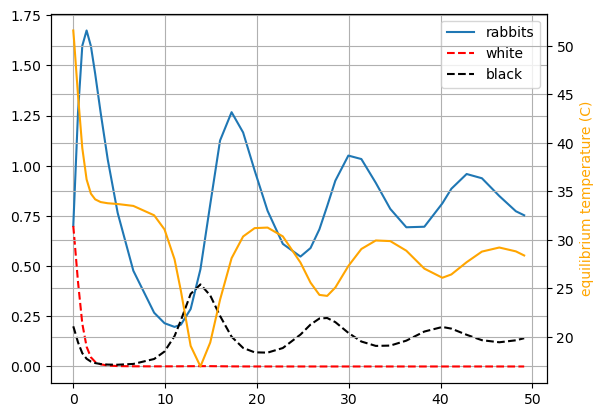

In [95]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(r_timeVals,r_yvals[:,2],label='rabbits')
ax1.plot(r_timeVals,r_yvals[:,1],'--r',label='white')
ax1.plot(r_timeVals,r_yvals[:,0],'--k',label='black')
ax1.legend()
ax1.grid()

ax2 = ax1.twinx()

ax2.plot(r_timeVals,eTemp,color='orange')
ax2.set_ylabel('equilibrium temperature (C)',color='orange')
ax2.grid()


Massive jump in the rabbit population correlated to the higher values of both daisies. 

Rabbit population drops as the daisy coverage decreases. 

Black daisy population jumps, as a result, so does the rabbit populations

oscillation between black daisies? what are the temps?


In [76]:
r_yvals[0,:3]

array([0.2, 0.7, 0.7])

In [77]:
eTemp = [] 
for i in range(len(r_timeVals)):
    dont, care, e = rabSolver.find_temp(r_yvals[i,:2])
    eTemp.append(e-273.15)


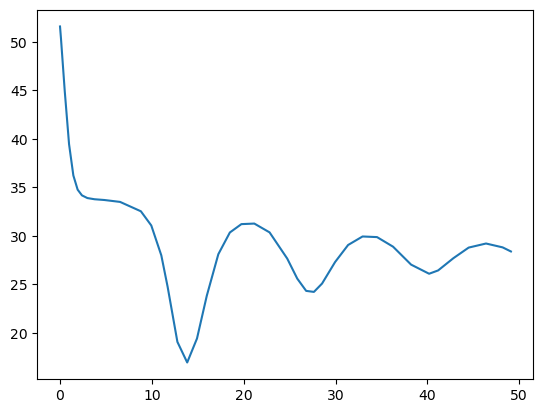

In [78]:
plt.plot(r_timeVals,eTemp)

Ok. My problem here is the way im defining the 